In [10]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from scipy.stats import norm

In [11]:
# Load data – training and test
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [12]:
#Normalize and Reshape images (flatten)
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr_flat, x_te_flat = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)

In [13]:
print(x_tr.shape, x_te.shape)
print(x_tr_flat.shape, x_te_flat.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 784) (10000, 784)


In [14]:
# Neural Network Parameters
batch_size, n_epoch = 100, 50
n_hidden, z_dim = 256, 2

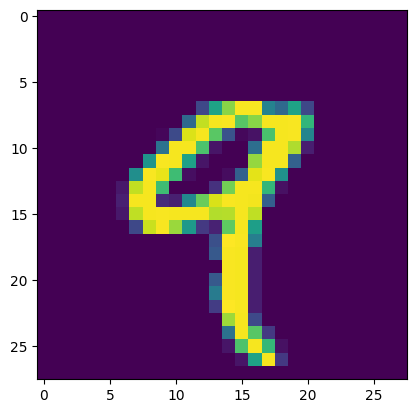

In [15]:
# Example of a training image
plt.imshow(x_tr[4]);

In [16]:
# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

In [17]:
x_tr_flat.shape[1:]

(784,)

In [18]:
# Encoder - from 784->256->128->2
inputs_flat = Input(shape=(x_tr_flat.shape[1:]))
x_flat = Dense(n_hidden, activation='relu')(inputs_flat) # first hidden layer
x_flat = Dense(n_hidden//2, activation='relu')(x_flat)  # second hidden layer

# hidden state, which we will pass into the Model to get the Encoder.
mu_flat = Dense(z_dim)(x_flat)
log_var_flat = Dense(z_dim)(x_flat)
z_flat = Lambda(sampling, output_shape=(z_dim,))([mu_flat, log_var_flat])

In [19]:
#Decoder - from 2->128->256->784
latent_inputs = Input(shape=(z_dim,))
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr_flat.shape[1], activation='sigmoid')
z_decoded = z_decoder1(latent_inputs)
z_decoded = z_decoder2(z_decoded)
y_decoded = y_decoder(z_decoded)
decoder_flat = Model(latent_inputs, y_decoded, name="decoder_conv")

outputs_flat = decoder_flat(z_flat)

In [20]:
# variational autoencoder (VAE) - to reconstruction input
reconstruction_loss = losses.binary_crossentropy(inputs_flat,
                                                 outputs_flat) * x_tr_flat.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu_flat) + K.exp(log_var_flat) - log_var_flat - 1, axis = -1)
vae_flat_loss = reconstruction_loss + kl_loss

# Build model
#  Ensure that the reconstructed outputs are as close to the inputs
vae_flat = Model(inputs_flat, outputs_flat)
vae_flat.add_loss(vae_flat_loss)
vae_flat.compile(optimizer='adam')

In [21]:
# train
vae_flat.fit(
    x_tr_flat,
    shuffle=True,
    epochs=n_epoch,
    batch_size=batch_size,
    validation_data=(x_te_flat, None),
    verbose=1
)

Epoch 1/50
600/600 [==============================] - 8s 5ms/step - loss: 195.7124 - val_loss: 170.4207
Epoch 2/50
600/600 [==============================] - 2s 4ms/step - loss: 165.5762 - val_loss: 161.0090
Epoch 3/50
600/600 [==============================] - 2s 4ms/step - loss: 159.0966 - val_loss: 156.8029
Epoch 4/50
600/600 [==============================] - 3s 5ms/step - loss: 155.4935 - val_loss: 153.5723
Epoch 5/50
600/600 [==============================] - 3s 6ms/step - loss: 153.0029 - val_loss: 151.6456
Epoch 6/50
600/600 [==============================] - 3s 5ms/step - loss: 151.7136 - val_loss: 150.6780
Epoch 7/50
600/600 [==============================] - 2s 4ms/step - loss: 149.6416 - val_loss: 148.7239
Epoch 8/50
600/600 [==============================] - 3s 4ms/step - loss: 148.2100 - val_loss: 147.4261
Epoch 9/50
600/600 [==============================] - 3s 4ms/step - loss: 146.8683 - val_loss: 146.5355
Epoch 10/50
600/600 [==============================] - 3s 5ms/st

In [22]:
import pandas as pd

history = Out

In [25]:
history = history[21]

In [26]:
history

Minimum validation loss: 137.312255859375


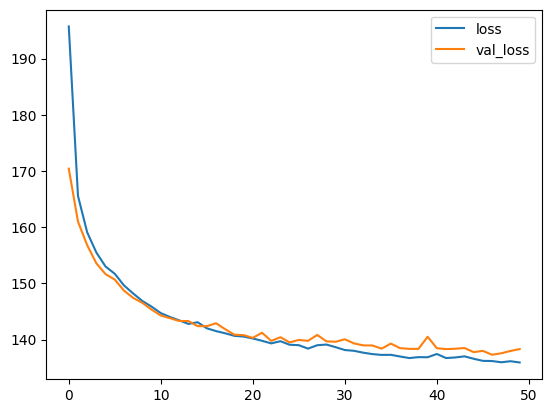

In [27]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

### Visualizzare gli embeddings


In [28]:
# Build encoders
encoder_f = Model(inputs_flat, z_flat)  # flat encoder

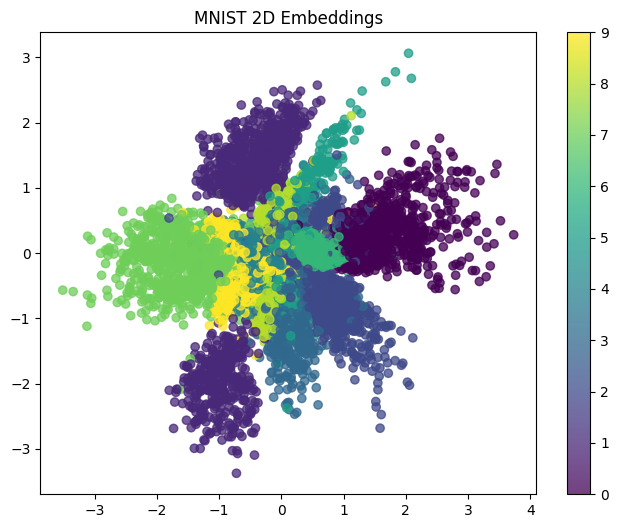

In [29]:
# Plot of the digit classes in the latent space
x_te_latent = encoder_f.predict(x_te_flat, batch_size=batch_size,verbose=0)
plt.figure(figsize=(8, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te, alpha=0.75)
plt.title('MNIST 2D Embeddings')
plt.colorbar()
plt.show()

In [30]:
y_te.shape

(10000,)

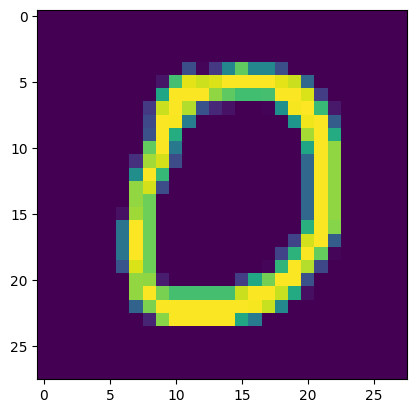

In [31]:
plt.imshow(x_te_flat[10].reshape(28,28));

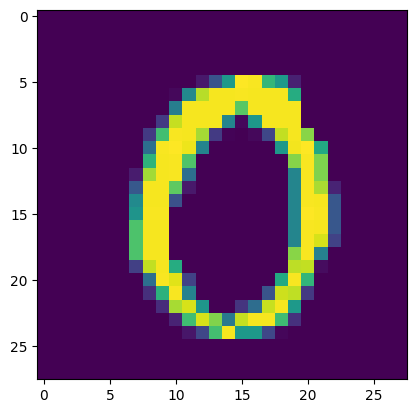

In [32]:
plt.imshow(x_te_flat[13].reshape(28,28));

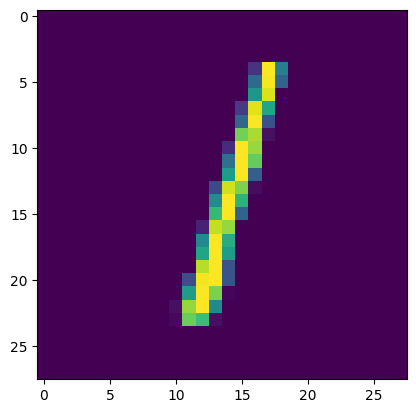

In [33]:
plt.imshow(x_te_flat[2].reshape(28,28));

In [34]:
# calculate vectors for each digit
zero_A = x_te_latent[10]
zero_B = x_te_latent[13]
one = x_te_latent[2]

print(f"Embedding for the first ZERO is  {zero_A}")
print(f"Embedding for the second ZERO is {zero_B}")
print(f"Embedding for the ONE is         {one}")

Embedding for the first ZERO is  [1.6275742  0.15146708]
Embedding for the second ZERO is [1.2826418  0.09503315]
Embedding for the ONE is         [-0.70920926  1.8172088 ]


In [35]:
pip install -U sentence-transformers

In [36]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [37]:
#Sentences we want to encode. Example:
sentence = ['The team enjoyed the hike through the meadow',
            'The national park had great views',
            'Olive oil drizzled over pizza tastes delicious']

In [38]:
#Sentences are encoded by calling model.encode()
embedding = model.encode(sentence)

#Preview the embeddings
print(embedding)

[[ 0.37061954  0.26414254  0.21265697 ...  0.14994547 -0.25794908
  -0.23970756]
 [ 0.6693326   0.40094948 -0.48208374 ...  0.10645893 -1.506716
  -0.01547348]
 [-0.26555923  0.11172376 -0.14733064 ...  0.42197463  0.88394594
   0.10763925]]


In [39]:
embedding.shape

(3, 384)

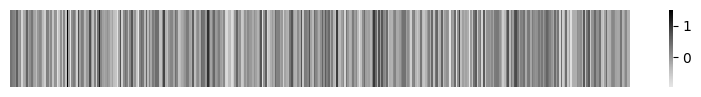

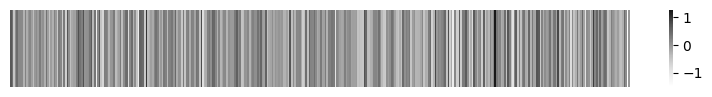

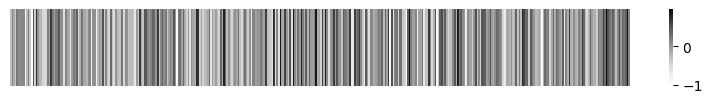

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(embedding[0].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[1].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[2].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

### Distanze vettoriali

In [41]:
# Euclidean Distance
L2 = [(zero_A[i] - zero_B[i])**2 for i in range(len(zero_A))]
L2 = np.sqrt(np.array(L2).sum())
print(L2)

0.34951849087528536


In [42]:
#Calculate L2 distances
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=2))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=2))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=2))

Distance zeroA-zeroB: 0.34951848
Distance zeroA-one:   2.8697128
Distance zeroB-one:   2.6331275


In [43]:
#Calculate L1 distances
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=1))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=1))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=1))

Distance zeroA-zeroB: 0.40136638
Distance zeroA-one:   4.0025253
Distance zeroB-one:   3.7140267


In [45]:
#Calculate Dot products
print("Dot Product zeroA-zeroB:", np.dot(zero_A, zero_B))
print("Dot Product zeroA-one:  ", np.dot(zero_A, one))
print("Dot Product zeroB-one:  ", np.dot(zero_B, one))

Dot Product zeroA-zeroB: 2.101989
Dot Product zeroA-one:   -0.87904334
Dot Product zeroB-one:   -0.7369664


In [46]:
# Cosine Distance
cosine = 1 - np.dot(zero_A,zero_B)/(np.linalg.norm(zero_A)*np.linalg.norm(zero_B))
print(f"{cosine:.6f}")

0.000177


In [47]:
# Cosine Distance function
def cosine_distance(vec1,vec2):
  cosine = 1 - (np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))
  return cosine

In [48]:
#Cosine Distance
print(f"Distance zeroA-zeroB: {cosine_distance(zero_A, zero_B): .6f}")
print(f"Distance zeroA-one:   {cosine_distance(zero_A, one): .6f}")
print(f"Distance zeroB-one:   {cosine_distance(zero_B, one): .6f}")

Distance zeroA-zeroB:  0.000177
Distance zeroA-one:    1.275681
Distance zeroB-one:    1.293740


In [49]:
#Dot Product
print("Distance 0-1:", np.dot(embedding[0], embedding[1]))
print("Distance 0-2:", np.dot(embedding[0], embedding[2]))
print("Distance 1-2:", np.dot(embedding[1], embedding[2]))

Distance 0-1: 26.497887
Distance 0-2: 2.0785804
Distance 1-2: 4.0192156


In [50]:
#Cosine Distance
print("Distance 0-1: ", cosine_distance(embedding[0], embedding[1]))
print("Distance 0-2: ", cosine_distance(embedding[0], embedding[2]))
print("Distance 1-2: ", cosine_distance(embedding[1], embedding[2]))

Distance 0-1:  0.5350335836410522
Distance 0-2:  0.9639392681419849
Distance 1-2:  0.9288790225982666
